# Tensorflow V2.0 图像识别教程

教程参考官方专家高级教程：
https://tensorflow.google.cn/tutorials/quickstart/advanced?hl=en

这里以 TinyMind 《汉字书法识别》比赛数据为例，展示使用 Tensorflow V2.0 进行图像数据分类模型训练的整个流程。

数据地址请参考:
https://www.tinymind.cn/competitions/41#property_23

或到这里下载：
自由练习赛数据下载地址：
训练集：链接: https://pan.baidu.com/s/1UxvN7nVpa0cuY1A-0B8gjg 密码: aujd

测试集: https://pan.baidu.com/s/1tzMYlrNY4XeMadipLCPzTw 密码: 4y9k

# 数据探索
请参考官方的数据说明

# 数据处理

竞赛中只有训练集 train 数据有准确的标签，因此这里只使用 train 数据即可，实际应用中，阶段 1、2 的榜单都需要使用。

## 数据下载

下载数据之后进行解压，得到 train 文件夹，里面有 100 个文件夹，每个文件夹名字即是各个汉字的标签。类似的数据集结构经常在分类任务中见到。可以使用下述命令验证一下每个文件夹下面文件的数量，看数据集是否符合竞赛数据描述：
```sh
for l in $(ls); do echo $l $(ls $l|wc -l); done
```

## 划分数据集

因为这里只使用了 train 集，因此我们需要对已有数据集进行划分，供模型训练的时候做验证使用，也就是 validation 集的构建。
> 一般认为，train 用来训练模型，validation 用来对模型进行验证以及超参数（ hyper parameter）调整，test 用来做模型的最终验证，我们所谓模型的性能，一般也是指 test 集上模型的性能指标。但是实际项目中，一般只有 train 集，同时没有可靠的 test 集来验证模型，因此一般将 train 集划分出一部分作为 validation，同时将 validation 上的模型性能作为最终模型性能指标。

> 一般情况下，我们不严格区分 validation 和 test。

这里将每个文件夹下面随机50个文件拿出来做 validation。

```sh
export train=train
export val=validation

for d in $(ls $train); do
    mkdir -p $val/$d/
    for f in $(ls train/$d | shuf | head -n 50 ); do
        mv $train/$d/$f $val/$d/;
    done;
done
```

> 需要注意，这里的 validation 只间接通过超参数的调整参与了模型训练。因此有一定的数据浪费。

# 模型训练代码-数据部分
首先导入 TF 看一下版本

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

训练模型的时候，模型内部全部都是数字，没有任何可读性，而且这些数字也需要人为给予一些实际的意义，这里将 100 个汉字作为模型输出数字的文字表述。

需要注意的是，因为模型训练往往是一个循环往复的过程，因此一个稳定的文字标签是很有必要的，这里利用相关 python 代码在首次运行的时候生成了一个标签文件，后续检测到这个标签文件，则直接调用即可。

In [2]:
import os

if os.path.exists("labels.txt"):
    with open("labels.txt") as inf:
        classes = [l.strip() for l in inf]
else:
    classes = os.listdir("worddata/train/")
    with open("labels.txt", "w") as of:
        of.write("\r\n".join(classes))

相比于 TF V1.x，V2.x 中一个比较大的变化就是数据集读取和处理的工具更加简单，（虽然效率其实低了一些，但是考虑数据读取在一定的优化下，很少成为模型训练的瓶颈，这一点性能损失带来巨大的便利性，还是值得的）。

TF V2.x中提供了直接从目录中读取数据并进行训练的 API 这里使用的API如下。

这里使用了两个数据集，分别代表 train、validation。

需要注意的是，由于 数据中，使用的图像数据集，其数值在（0， 255）之间，不适合直接输入模型进行训练，因此这里使用 rescale 对数据进行缩放。同时，train 数据集做了一定的数据预处理（旋转、明暗度），用于进行数据增广，而 validation则不需要做类似的变换。

In [3]:
img_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0, rotation_range=15, brightness_range=(0.5, 1.0)
)
img_gen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

从 API 的名称和参数可以看出，这个 API 并不直接从目录中读取数据，我们实际使用的时候，要使用这个 API 的一个封装。

在这个封装中，我们指定了图像最终的大小（target_size），颜色模式（color_mode），批量大小（batch_size），同时还有一个非常重要的标签（classes）。

需要注意的是，这里的 color_mode 使用的是灰度模式，读取出来的数据只有一个颜色通道，因为书法的汉字全部是水墨，无所谓颜色。而 classes的使用，保证每次模型训练都使用统一的标签，如果不指定，那么这个 API 会按照一个内置的规则对标签进行编号，这个编号在不同的系统平台之间可能是不一致的。

这里还需要注意一点的是，train 集我们对数据进行了随机打乱 (shuffle)， 而 validation 则没有。

In [4]:
img_train = img_gen_train.flow_from_directory(
    "worddata/train/",
    target_size=(128, 128),
    color_mode="grayscale",
    classes=classes,
    batch_size=32,
    shuffle=True,
)
img_val = img_gen_train.flow_from_directory(
    "worddata/validation/",
    target_size=(128, 128),
    color_mode="grayscale",
    classes=classes,
    batch_size=32,
)

Found 35008 images belonging to 100 classes.
Found 5000 images belonging to 100 classes.


到这里，这两个数据集就可以使用了，正式模型训练之前，我们可以先来看看这个数据集是怎么读取数据的，读取出来的数据又是设么样子的。

In [5]:
imgs, labels = next(img_train)
# 因为是 generator 所以可以用next来读取
imgs.shape, labels.shape

((32, 128, 128, 1), (32, 100))

可以看到数据是（batch, width, height, channel）, 因为这里是灰度图像，因此 channel 是 1。

> 需要注意，pyTorch、mxnet使用的数据 layout 与Tensorflow 不同，因此数据也有一些不同的处理方式。

把图片打印出来看看，看看数据和标签之间是否匹配


'从'

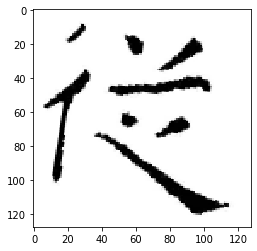

In [6]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(imgs[0, :, :, 0], cmap="gray")
classes[np.argsort(labels[0, :])[-1]]

# 模型训练代码-模型构建

TF V2.x 中使用动态图来构建模型，同时由于使用了 keras的 API，因此模型构建比较简单了。这里演示的是使用 class的方式构建模型，对于简单模型，还可以直接使用 Sequential 进行构建。

这里的复杂模型也是用 Sequential 的简单模型进行的叠加。

> 这里构建的是VGG模型，关于VGG模型的更多细节请参考 1409.1556。

In [7]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # 模型有两个主要部分，特征提取层和分类器

        # 这里是特征提取层
        self.feature = tf.keras.models.Sequential()
        self.feature.add(self.conv(64))
        self.feature.add(self.conv(64, add_pooling=True))

        self.feature.add(self.conv(128))
        self.feature.add(self.conv(128, add_pooling=True))

        self.feature.add(self.conv(256))
        self.feature.add(self.conv(256))
        self.feature.add(self.conv(256, add_pooling=True))

        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512, add_pooling=True))

        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512))
        self.feature.add(self.conv(512, add_pooling=True))

        self.feature.add(tf.keras.layers.GlobalAveragePooling2D())

        self.feature.add(tf.keras.layers.Dense(4096))
        self.feature.add(tf.keras.layers.BatchNormalization())
        self.feature.add(tf.keras.layers.Dense(4096))
        self.feature.add(tf.keras.layers.BatchNormalization())

        self.feature.add(tf.keras.layers.Dropout(0.5))

        # 这个简单的机构是分类器
        # 这里我们将 softmax的操作直接加入了模型结构中。
        # 而很多框架的 model zoo 中的模型将 softmax
        # 的操作放在模型外执行，可以大大提高模型的灵活性，
        # 方便对模型的最终输出做一些其他处理。
        self.pred = tf.keras.models.Sequential(
            [tf.keras.layers.Dense(100, activation=None), tf.keras.layers.Softmax(),]
        )

    def conv(self, filters, add_pooling=False):
        # 模型大量使用重复模块构建，
        # 这里将重复模块提取出来，简化模型构建过程
        model = tf.keras.models.Sequential(
            [
                tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu"),
                tf.keras.layers.BatchNormalization(),
            ]
        )
        if add_pooling:
            model.add(
                tf.keras.layers.MaxPool2D(
                    pool_size=(2, 2), strides=None, padding="same"
                )
            )
        return model

    def call(self, x):
        # call 用来定义模型各个结构之间的运算关系

        x = self.feature(x)
        return self.pred(x)

可以看到，上述模型定义中，仅仅关注当前模块的参数即可，模块的输入及输出的关系由框架自动推算得到，节省了很多精力。

> 这跟 TF 1.x 有很大不同，也跟 pyTorch有很大不同。mxnet 的 gluon api 跟这里的操作是类似的。

实例化一个模型看看：

In [8]:
model = MyModel()

model.build(input_shape=(None, 128, 128, 1))
# 这里的build，是因为模型构建的时候，并没有指定输入数据的尺寸，
# 因此要查看模型的一些数据，需要告知模型的输入数据尺寸，框架据
# 此推断模型内部各模块参数。
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      multiple                  33645760  
_________________________________________________________________
sequential_14 (Sequential)   multiple                  409700    
Total params: 34,055,460
Trainable params: 34,030,628
Non-trainable params: 24,832
_________________________________________________________________


build 和 summary 仅仅用来查看模型数据，对于模型训练不是必须的

# 模型训练代码-训练相关部分
要训练模型，我们还需要定义损失，优化器等，同时为了方便训练过程对模型进行验证，我们还需要定义一些性能指标。

In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam() # 优化器有些参数可以设置
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name="train_accuracy")

val_loss = tf.keras.metrics.Mean(name="val_loss")
val_accuracy = tf.keras.metrics.CategoricalAccuracy(name="val_accuracy")

TF V1.x 中，模型的训练是需要启动一个 Session 的，而在 TF V2.x中，这个 Session的操作被隐藏了起来，取而代之的是 tf.function。

In [10]:
@tf.function
def train_step(imgs, labels):
    with tf.GradientTape() as tape:
        # tape 用来追踪整个计算图，并记录梯度
        preds = model(imgs, training=True)
        loss = loss_object(labels, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, preds)


@tf.function
def val_step(imgs, labels):
    # 验证的时候，我们不需要进行梯度更新，
    # 也就不需要使用tape
    preds = model(imgs, training=True)
    loss = loss_object(labels, preds)

    val_loss(loss)
    val_accuracy(labels, preds)

In [11]:
import time  # 模型训练的过程中手动追踪一下模型的训练速度

因为模型整个训练过程一般是一个循环往复的过程，所以经常性的保存重启模型训练中间过程是有必要的，这里使用 checkpoint 来保存模型中间训练结果，TF 整个系列对 checkpoint 的处理都很方便，这个目前是其他框架有欠缺的部分。

In [12]:
ckpt = tf.train.get_checkpoint_state(".")
# 检查 checkpoint 是否存在
if ckpt:
    # 如果存在，则加载 checkpoint
    model.load_weights(ckpt.model_checkpoint_path)
    # 这里是一个比较生硬的方式，其实还可以观察之前训练的过程，
    # 手动选择准确率最高的某次 checkpoint 进行加载。
    print("model lodaded")

In [13]:
EPOCHS = 20
for epoch in range(EPOCHS):
    # 验证数据都是针对整个 epoch 的，
    # 所以每个 epoch 之间要对这些数据初始化一下。
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    total_trained = 0
    total_valed = 0

    start = time.time()

    for imgs, labels in img_gen_train.flow_from_directory(
        "worddata/train/",
        target_size=(128, 128),
        color_mode="grayscale",
        classes=classes,
        batch_size=32,
        shuffle=True,
    ):
        # 之前生成的 img_train 是个 generator，而且它不会自动重启和结束，
        # 一旦启动，只要不手动结束，它会一直无限循环输出数据，因此这里手动处
        # 理一下数据的生成，并做一个计数。

        train_step(imgs, labels)
        total_trained += imgs.shape[0]
        if total_trained > 35000:
            break
    period = time.time() - start
    train_samples_per_second = total_trained / period

    start = time.time()
    for imgs, labels in img_gen_val.flow_from_directory(
        "worddata/validation/",
        target_size=(128, 128),
        color_mode="grayscale",
        classes=classes,
        batch_size=32,
    ):
        val_step(imgs, labels)
        total_valed += imgs.shape[0]
        if total_valed > 5000:
            break
    period = time.time() - start
    val_samples_per_second = total_valed / period

    print(
        "Epoch {} Loss {}, Acc {}, Val Loss {}, Val Acc {}".format(
            epoch,
            train_loss.result(),
            train_accuracy.result() * 100,
            val_loss.result(),
            val_accuracy.result() * 100,
        )
    )
    print(
        "Speed train {}imgs/s val {}imgs/s".format(
            train_samples_per_second, val_samples_per_second
        )
    )
    model.save_weights("model-{:04d}.ckpt".format(epoch))
    # 每个 epoch 保存一下模型，需要注意每次
    # 保存要用一个不同的名字，不然会导致覆盖，
    # 同时还要关注一下磁盘空间占用，防止太多
    # chekcpoint 占满磁盘空间导致错误。
    # 注意这个 API 调用每次都会生成数个文件，
    # 其中 checkpoint 文件用来记录每次的文
    # 件路径，其他文件则存储模型数据和索引信息

Found 35008 images belonging to 100 classes.
Found 5000 images belonging to 100 classes.
Epoch 0 Loss 7.013031005859375, Acc 1.0654706954956055, Val Loss 8.230669975280762, Val Acc 1.3314785957336426
Speed train 143.29322678521348imgs/s val 388.28456133362556imgs/s
Found 35008 images belonging to 100 classes.
Found 5000 images belonging to 100 classes.
Epoch 1 Loss 6.983994960784912, Acc 1.191156268119812, Val Loss 7.239212989807129, Val Acc 1.58982515335083
Speed train 145.07717649867584imgs/s val 424.40105396584045imgs/s
Found 35008 images belonging to 100 classes.
Found 5000 images belonging to 100 classes.
Epoch 2 Loss 6.847441673278809, Acc 1.1654479503631592, Val Loss 6.265858173370361, Val Acc 1.4904611110687256
Speed train 145.08648051146173imgs/s val 424.310391109837imgs/s
Found 35008 images belonging to 100 classes.
Found 5000 images belonging to 100 classes.
Epoch 3 Loss 6.723228454589844, Acc 1.4739488363265991, Val Loss 6.485783576965332, Val Acc 1.073132038116455
Speed tr

# 一些技巧

因为这里定义的模型比较大，同时训练的数据也比较多，每个 epoch 用时较长，因此，如果代码有 bug 的话，经过一次 epoch 再去 debug 效率比较低。

这种情况下，我们使用的数据生成过程又是自己手动指定数据数量的，因此可以尝试缩减模型规模，定义小一些的数据集来快速验证代码。在这个例子里，我们可以通过注释模型中的卷积和全连接层的代码来缩减模型尺寸，通过修改训练循环里面的数据数量来缩减数据数量。